In [1]:
import vit
from dataset import Yoga82
from dataset_utils import calculate_mean_std, get_train, get_test
from train import train
from eval import model_analysis
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# Settings
config = {
    "num_classes": 82,
    "img_size": 224,
    "img_channels": 3,
    "patch_size": 32,
    "hidden_size": 768,
    "hidden_dropout": 0.1,
    "attention_dropout": 0.1,
    "num_hidden_layers": 12,
    "num_attention_heads": 12,
    "mlp_hidden_size": 3072,
    "initializer_range": 0.02,
    "learning_rate": 3e-6,
    "betas": (0.9, 0.999),
    "weight_decay": 0.03,
    "batch_size": 32,
    "device": 'cuda',
    "epochs": 200,
    "hierarchy_level": 1,
    "load_pretrained": False,
    "transfer_learning": False,
}

In [3]:
# Get Train and Test image paths and respective labels for each hierarchy.
X_train, y_train_6, y_train_20, y_train_82 = get_train()
X_test, y_test_6, y_test_20, y_test_82 = get_test()

if config["hierarchy_level"] == 1:
    y_train = y_train_6
    y_test = y_test_6
    config["num_classes"] = 6
elif config["hierarchy_level"] == 2:
    y_train = y_train_20
    y_test = y_test_20
    config["num_classes"] = 20
elif config["hierarchy_level"] == 3:
    y_train = y_train_82
    y_test = y_test_82
    config["num_classes"] = 82

Train Dataset Total: 14976
Test Dataset Total: 5131


In [4]:
### DATASET PREPARATION ###

## Calculate mean and std per channel from X_train for Normalization.
# Takes a while, so save it after you do it so you don't have to compute it next time :3

# mean, std = calculate_mean_std(X_train)
mean = [0.6732, 0.6525, 0.6263]
std = [0.2339, 0.2360, 0.2378]

print("Mean:", mean)
print("Std:", std)

## Tranformations for Data Augmentation and Normalization

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_transforms = transforms.Compose([
    transforms.Normalize(mean=mean, std=std),
])

## Generate Train and Test Datasets
# Takes about 5 minutes for me uwu
train_dataset = Yoga82(X_train, y_train, transform=train_transforms, resize=config["img_size"], num_channels=config["img_channels"])
test_dataset = Yoga82(X_test, y_test, transform=test_transforms, resize=config["img_size"], num_channels=config["img_channels"])

Mean: [0.6732, 0.6525, 0.6263]
Std: [0.2339, 0.236, 0.2378]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


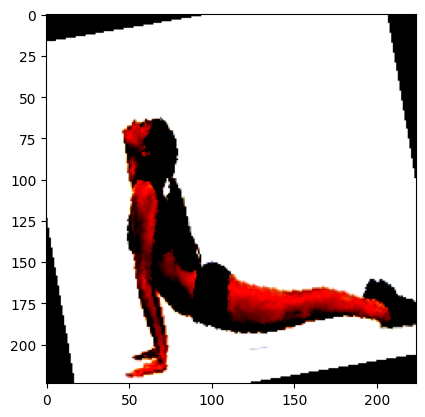

In [5]:
# Display an Image Example
import matplotlib.pyplot as plt
plt.imshow(train_dataset[2345][0].numpy().transpose(1,2,0))

In [6]:
# Create a Sampler to Balance Dataset
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

class_weights = compute_class_weight('balanced', classes=range(max(y_train)+1), y=y_train)
class_weights = 1.0  /torch.tensor(class_weights, dtype=torch.float32)
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

#Create model and training parameters
device = config["device"]
batch_size = config["batch_size"]
lr = config["learning_rate"]
betas = config["betas"]
weight_decay = config["weight_decay"]
model = vit.ViT(config).to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Load a pretrained State or Backbone
#if config["load_pretrained"]:
#    checkpoint = torch.load('model_82_classes.pth')
#
#    #Remove Clasification MLP W and B for Transfer Learning
#    if config["transfer_learning"]:
#        checkpoint['model_state_dict'].pop('cls_layer.weight', None)
#        checkpoint['model_state_dict'].pop('cls_layer.bias', None)
#
#    model.load_state_dict(checkpoint['model_state_dict'], strict=False)

In [8]:
train(model, train_dataloader, optimizer, criterion, scheduler, config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: felipeandres-valenzuelar (pipper). Use `wandb login --relogin` to force relogin


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 1 - Loss: 1.665579462917442 - Model checkpoint saved to model_checkpoint_epoch_1.pth


100%|██████████| 468/468 [02:45<00:00,  2.83it/s]


Epoch 2 - Loss: 1.6609423909431849 - Model checkpoint saved to model_checkpoint_epoch_2.pth


100%|██████████| 468/468 [02:45<00:00,  2.84it/s]


Epoch 3 - Loss: 1.6552219953801897 - Model checkpoint saved to model_checkpoint_epoch_3.pth


100%|██████████| 468/468 [02:43<00:00,  2.86it/s]


Epoch 4 - Loss: 1.652767405550704 - Model checkpoint saved to model_checkpoint_epoch_4.pth


100%|██████████| 468/468 [02:45<00:00,  2.83it/s]


Epoch 5 - Loss: 1.6605434086587694 - Model checkpoint saved to model_checkpoint_epoch_5.pth


100%|██████████| 468/468 [02:43<00:00,  2.86it/s]


Epoch 6 - Loss: 1.6576527046342182 - Model checkpoint saved to model_checkpoint_epoch_6.pth


100%|██████████| 468/468 [02:42<00:00,  2.88it/s]


Epoch 7 - Loss: 1.6567874713840647 - Model checkpoint saved to model_checkpoint_epoch_7.pth


100%|██████████| 468/468 [02:42<00:00,  2.87it/s]


Epoch 8 - Loss: 1.661168928584482 - Model checkpoint saved to model_checkpoint_epoch_8.pth


100%|██████████| 468/468 [02:42<00:00,  2.89it/s]


Epoch 9 - Loss: 1.6589490363740513 - Model checkpoint saved to model_checkpoint_epoch_9.pth


100%|██████████| 468/468 [02:42<00:00,  2.88it/s]


Epoch 10 - Loss: 1.6582740779615874 - Model checkpoint saved to model_checkpoint_epoch_10.pth


100%|██████████| 468/468 [02:42<00:00,  2.88it/s]


Epoch 11 - Loss: 1.6650920342176387 - Model checkpoint saved to model_checkpoint_epoch_11.pth


100%|██████████| 468/468 [02:42<00:00,  2.88it/s]


Epoch 12 - Loss: 1.659683427749536 - Model checkpoint saved to model_checkpoint_epoch_12.pth


100%|██████████| 468/468 [02:41<00:00,  2.89it/s]


Epoch 13 - Loss: 1.6606073697917483 - Model checkpoint saved to model_checkpoint_epoch_13.pth


100%|██████████| 468/468 [02:45<00:00,  2.83it/s]


Epoch 14 - Loss: 1.6625896358591878 - Model checkpoint saved to model_checkpoint_epoch_14.pth


100%|██████████| 468/468 [02:51<00:00,  2.74it/s]


Epoch 15 - Loss: 1.656520357498756 - Model checkpoint saved to model_checkpoint_epoch_15.pth


100%|██████████| 468/468 [02:50<00:00,  2.74it/s]


Epoch 16 - Loss: 1.6569711927674775 - Model checkpoint saved to model_checkpoint_epoch_16.pth


100%|██████████| 468/468 [02:49<00:00,  2.77it/s]


Epoch 17 - Loss: 1.6605417218982663 - Model checkpoint saved to model_checkpoint_epoch_17.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 18 - Loss: 1.6570575018214364 - Model checkpoint saved to model_checkpoint_epoch_18.pth


100%|██████████| 468/468 [02:51<00:00,  2.73it/s]


Epoch 19 - Loss: 1.658943811033526 - Model checkpoint saved to model_checkpoint_epoch_19.pth


100%|██████████| 468/468 [02:49<00:00,  2.75it/s]


Epoch 20 - Loss: 1.6597746399223294 - Model checkpoint saved to model_checkpoint_epoch_20.pth


100%|██████████| 468/468 [02:49<00:00,  2.75it/s]


Epoch 21 - Loss: 1.6537068608479621 - Model checkpoint saved to model_checkpoint_epoch_21.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 22 - Loss: 1.658017531164691 - Model checkpoint saved to model_checkpoint_epoch_22.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 23 - Loss: 1.662933822371002 - Model checkpoint saved to model_checkpoint_epoch_23.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 24 - Loss: 1.6601004129291599 - Model checkpoint saved to model_checkpoint_epoch_24.pth


100%|██████████| 468/468 [02:50<00:00,  2.74it/s]


Epoch 25 - Loss: 1.6600959489488194 - Model checkpoint saved to model_checkpoint_epoch_25.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 26 - Loss: 1.662635647588306 - Model checkpoint saved to model_checkpoint_epoch_26.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 27 - Loss: 1.6583419248589084 - Model checkpoint saved to model_checkpoint_epoch_27.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 28 - Loss: 1.6558648299457681 - Model checkpoint saved to model_checkpoint_epoch_28.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 29 - Loss: 1.660307560975735 - Model checkpoint saved to model_checkpoint_epoch_29.pth


100%|██████████| 468/468 [02:49<00:00,  2.77it/s]


Epoch 30 - Loss: 1.656820955948952 - Model checkpoint saved to model_checkpoint_epoch_30.pth


100%|██████████| 468/468 [02:48<00:00,  2.77it/s]


Epoch 31 - Loss: 1.6610267862804935 - Model checkpoint saved to model_checkpoint_epoch_31.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 32 - Loss: 1.659430386673691 - Model checkpoint saved to model_checkpoint_epoch_32.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 33 - Loss: 1.6568415017209501 - Model checkpoint saved to model_checkpoint_epoch_33.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 34 - Loss: 1.657527154072737 - Model checkpoint saved to model_checkpoint_epoch_34.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 35 - Loss: 1.6599123760675774 - Model checkpoint saved to model_checkpoint_epoch_35.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 36 - Loss: 1.6589247273583698 - Model checkpoint saved to model_checkpoint_epoch_36.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 37 - Loss: 1.6624867121378581 - Model checkpoint saved to model_checkpoint_epoch_37.pth


100%|██████████| 468/468 [02:49<00:00,  2.77it/s]


Epoch 38 - Loss: 1.657211432599614 - Model checkpoint saved to model_checkpoint_epoch_38.pth


100%|██████████| 468/468 [02:48<00:00,  2.77it/s]


Epoch 39 - Loss: 1.6573576000001695 - Model checkpoint saved to model_checkpoint_epoch_39.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 40 - Loss: 1.6572886845494947 - Model checkpoint saved to model_checkpoint_epoch_40.pth


100%|██████████| 468/468 [02:49<00:00,  2.77it/s]


Epoch 41 - Loss: 1.6541519845143342 - Model checkpoint saved to model_checkpoint_epoch_41.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 42 - Loss: 1.6597601750977018 - Model checkpoint saved to model_checkpoint_epoch_42.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 43 - Loss: 1.6552410518002307 - Model checkpoint saved to model_checkpoint_epoch_43.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 44 - Loss: 1.657456137940415 - Model checkpoint saved to model_checkpoint_epoch_44.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 45 - Loss: 1.6628540155724583 - Model checkpoint saved to model_checkpoint_epoch_45.pth


100%|██████████| 468/468 [02:50<00:00,  2.74it/s]


Epoch 46 - Loss: 1.6573894986739526 - Model checkpoint saved to model_checkpoint_epoch_46.pth


100%|██████████| 468/468 [02:50<00:00,  2.75it/s]


Epoch 47 - Loss: 1.6544339218710222 - Model checkpoint saved to model_checkpoint_epoch_47.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 48 - Loss: 1.6570007574354482 - Model checkpoint saved to model_checkpoint_epoch_48.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 49 - Loss: 1.6575614827820377 - Model checkpoint saved to model_checkpoint_epoch_49.pth


100%|██████████| 468/468 [02:48<00:00,  2.77it/s]


Epoch 50 - Loss: 1.6596341831052406 - Model checkpoint saved to model_checkpoint_epoch_50.pth


100%|██████████| 468/468 [02:49<00:00,  2.76it/s]


Epoch 51 - Loss: 1.658781066409543 - Model checkpoint saved to model_checkpoint_epoch_51.pth


100%|██████████| 468/468 [02:51<00:00,  2.73it/s]


Epoch 52 - Loss: 1.657487575824444 - Model checkpoint saved to model_checkpoint_epoch_52.pth


 35%|███▌      | 165/468 [01:00<01:50,  2.73it/s]


KeyboardInterrupt: 

In [ ]:
#checkpoint = torch.load('model_checkpoint_epoch_5.pth')

#model.load_state_dict(checkpoint['model_state_dict'], strict=False)

<All keys matched successfully>

100%|██████████| 936/936 [03:30<00:00,  4.44it/s]


 Accuracy for Validation Dataset: 0.38448183760683763


0.38448183760683763

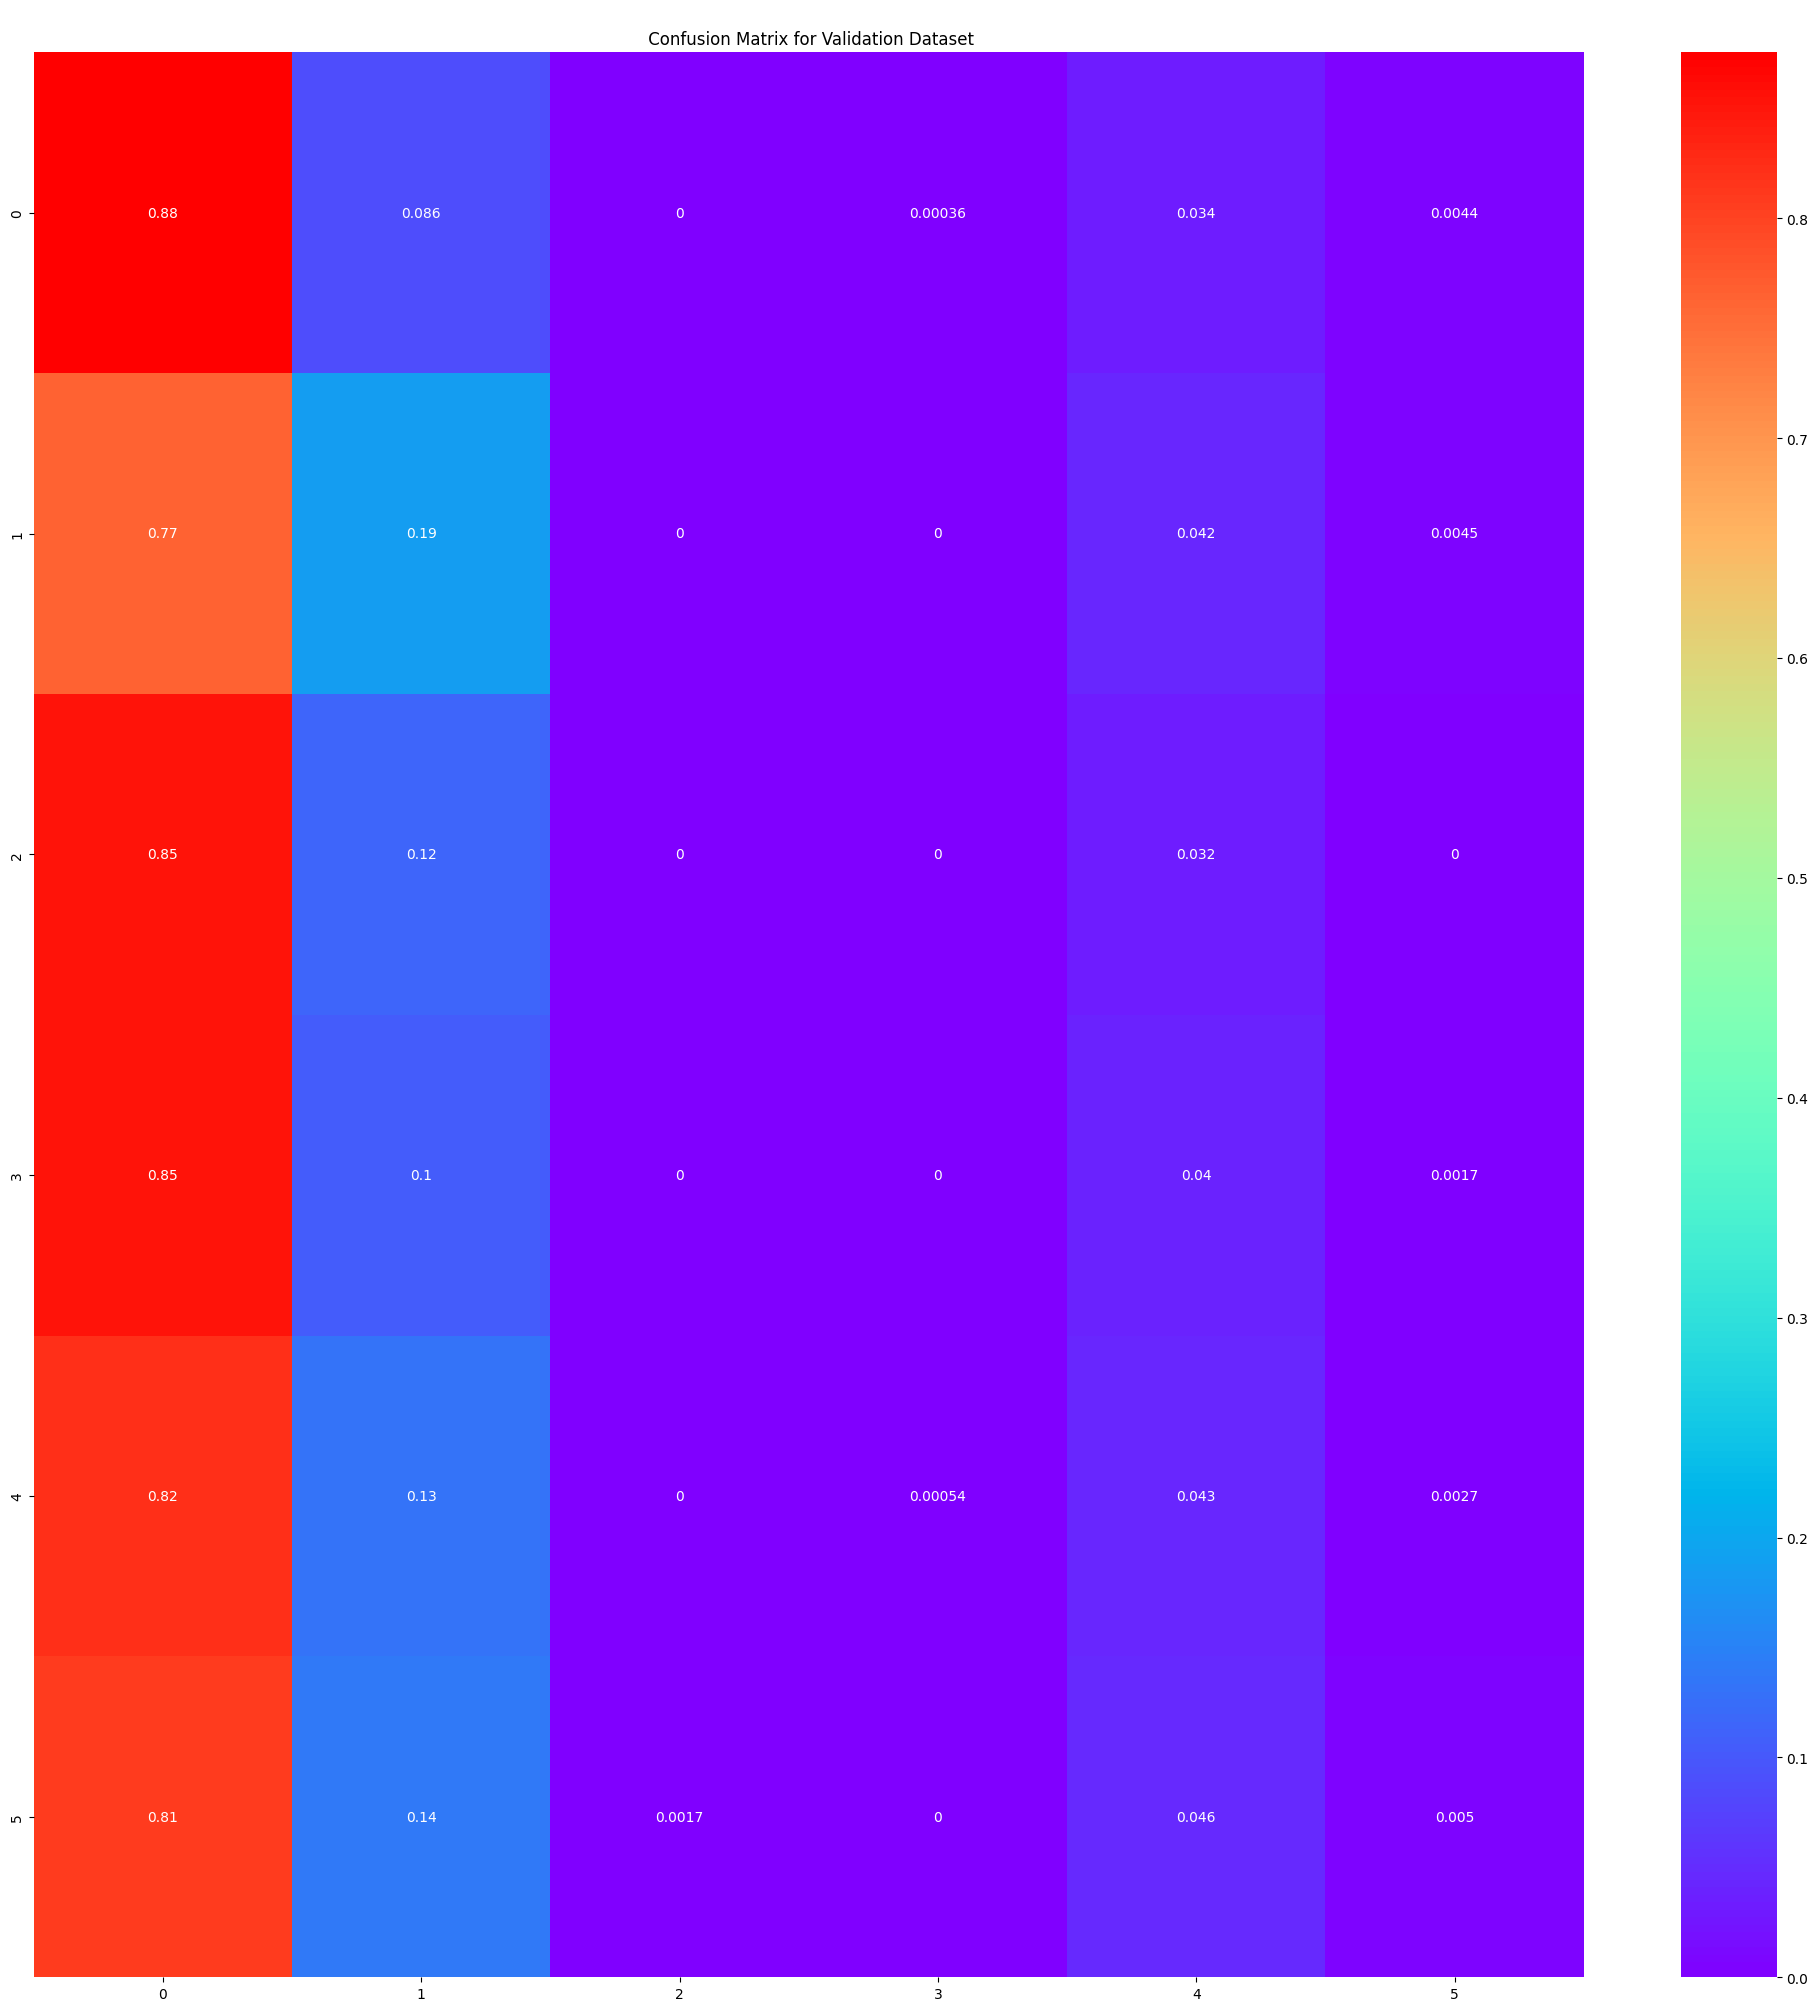

In [ ]:
model_analysis(model, train_dataloader, dataset_name='Train Dataset')